In [240]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import subprocess
import re
from matplotlib.patches import Patch
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import conversion



In [241]:
GIBS_CLUSTER_BIN = "gibbscluster-2.0/gibbscluster"
# Update PATH environment variable for R
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

In [262]:
def group_by_peptide(df:pd.DataFrame, n_samples:int, pattern, out_dir =None):
    """
    Groups peptides based on a given pattern(the library peptide form) and aggregates their counts.

    This function processes a DataFrame containing peptide sequences and their respective counts
    across multiple samples. It calculates the total peptide count, filters peptides matching a
    specific pattern, and aggregates them based on a cleaned version of the peptide sequence (without the GSG linker).

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame where each row represents a peptide with its associated counts. Merged dataframe from the Data_Merge python script.
    n_samples : int
        The number of sample columns to consider for aggregation, normally 6, 3 replicates of the protein panning and three for the control panning.
    pattern : str
        A regular expression pattern used to filter and extract peptides: a regular expression matching the peptide library.
    out_dir : str
        The output directory where the grouped peptide data will be saved as a CSV file.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame grouped by the cleaned peptide sequences, with counts aggregated and sorted.
        The valid peptides that have the form of the library. 
    """

    # Add a column for the total count across specific columns
    df["Total Count"] = df.iloc[:, 1:n_samples+1].sum(axis=1)

    df = df.dropna(subset=["peptide"])
    
    # Convert peptide column to string and remove obvious invalid entries
    df["peptide"] = df["peptide"].astype(str)
    df = df[df["peptide"] != "nan"]
    df = df[df["peptide"] != ""]
    df = df[df["peptide"].str.len() > 0]

    # Calculate total peptides and valid peptides
    total_peptides = df["Total Count"].sum()
    df["Consistent"] = df["peptide"].astype(str).str.contains(pattern)
    valid_peptides = df.loc[df["Consistent"], "Total Count"].sum()

    # Print results
    print(f"Total peptides: {total_peptides}")
    print(f"Valid peptides: {valid_peptides}")
    print(f"Success rate: {100 * valid_peptides / total_peptides:.2f}%")

    # Extract the clean peptide matching the pattern
    df["Clean Peptide"] = df['peptide'].astype(str).str.extract(f"({pattern})", expand=False)

    # Handle amino acid replacements safely
    df["Clean Peptide"] = df['Clean Peptide'].fillna("").astype(str).str.replace("*", "Q", regex=False)

    # Drop rows where Clean Peptide is empty or NaN
    df = df[df["Clean Peptide"].str.len() > 0]
    df = df[df["Clean Peptide"] != "nan"]

    # Aggregate by clean peptide and sort
    df_grouped = df.groupby("Clean Peptide", as_index=False).sum(numeric_only=True)
    df_grouped = df_grouped.sort_values("Total Count", ascending=False)

    df_grouped.reset_index(inplace=True, drop=True)

    # Drop unnecessary column
    df_grouped = df_grouped.drop(columns=["Consistent"], errors='ignore')

    # Save cleaned dataset
    if out_dir:
        df_grouped.to_csv(out_dir)

    return df_grouped

In [263]:
def plot_histograms(df_before, df_after, output_dir):
    """
    Plots histograms of CPM (counts per million) and counts before and after applying thresholds.
    
    Parameters:
    -----------
    df_before : pandas.DataFrame
        DataFrame before thresholds. The output dataframe from the group_by_peptide function.
    df_after : pandas.DataFrame
        DataFrame after thresholds.
    output_dir : str
        Directory to save the histogram plots.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of histograms
    sns.set_style("whitegrid")

    # Plot histograms for Control Count
    sns.histplot(df_before["Control Count"], bins=50, color="blue", alpha=0.5, label="Before", ax=axes[0, 0], log_scale=True)
    sns.histplot(df_after["Control Count"], bins=50, color="red", alpha=0.5, label="After", ax=axes[0, 0], log_scale=True)
    axes[0, 0].set_title("Control Count Distribution")
    axes[0, 0].set_xlabel("Control Count")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].legend()

    # Plot histograms for Experiment Count
    sns.histplot(df_before["Experiment Count"], bins=50, color="blue", alpha=0.5, label="Before", ax=axes[0, 1], log_scale=True)
    sns.histplot(df_after["Experiment Count"], bins=50, color="red", alpha=0.5, label="After", ax=axes[0, 1], log_scale=True)
    axes[0, 1].set_title("Experiment Count Distribution")
    axes[0, 1].set_xlabel("Experiment Count")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].legend()

    # Plot histograms for 
    #  Control
    sns.histplot(df_before["CPM_Control"], bins=50, color="blue", alpha=0.5, label="Before", ax=axes[1, 0], log_scale=True)
    sns.histplot(df_after["CPM_Control"], bins=50, color="red", alpha=0.5, label="After", ax=axes[1, 0], log_scale=True)
    axes[1, 0].set_title("CPM Control Distribution")
    axes[1, 0].set_xlabel("CPM Control")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].legend()

    # Plot histograms for CPM Experiment
    sns.histplot(df_before["CPM_Exp"], bins=50, color="blue", alpha=0.5, label="Before", ax=axes[1, 1], log_scale=True)
    sns.histplot(df_after["CPM_Exp"], bins=50, color="red", alpha=0.5, label="After", ax=axes[1, 1], log_scale=True)
    axes[1, 1].set_title("CPM Experiment Distribution")
    axes[1, 1].set_xlabel("CPM Experiment")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].legend()

    plt.tight_layout()

    # Save the figure
    hist_path = os.path.join(output_dir, "CPM_counts_histograms.png")
    plt.savefig(hist_path, dpi=300)
    plt.plot()
    plt.close()
    print(f"Histograms saved to {hist_path}")



In [ ]:
def filter_by_CPM(df: pd.DataFrame, output_dir: str = None, threshold_1=None, threshold_2=None, plot=False):
    """
    Filters peptides based on Counts Per Million (CPM) and specified thresholds (normally Experiment count>5 and CPM_exp>1).
    Use as input dataframe the output of the group_by_peptide function.
    Generates histograms before and after filtering.
    """
    control_columns = [col for col in df.columns if 'Control' in col]
    experiment_columns = [col for col in df.columns if 'Experiment' in col]

    if not control_columns or not experiment_columns:
        raise ValueError("No valid control or experiment columns found in the DataFrame.")

    df["Control Count"] = df.get(control_columns, 0).sum(axis=1)
    df["Experiment Count"] = df.get(experiment_columns, 0).sum(axis=1)

    total_control_count = df["Control Count"].sum()
    total_experiment_count = df["Experiment Count"].sum()

    df["CPM_Control"] = (df["Control Count"] / total_control_count) * 1e6 if total_control_count > 0 else 0
    df["CPM_Exp"] = (df["Experiment Count"] / total_experiment_count) * 1e6 if total_experiment_count > 0 else 0

    # Store original for histogram comparison
    df_before = df.copy()  
    # Apply filtering thresholds
    if threshold_1 is not None:
        df = df[df["Experiment Count"] > threshold_1]
    if threshold_2 is not None:
        df = df[df["CPM_Exp"] > threshold_2]

    # Store filtered for histogram comparison
    df_after = df.copy()  
    filtered_df = df.reset_index(drop=True)

    if output_dir:
        os.makedirs(os.path.dirname(output_dir), exist_ok=True)
        filtered_df.to_csv(output_dir, index=False)

    # Generate histograms
    if plot:
        plot_histograms(df_before, df_after, os.path.dirname(output_dir))

    return filtered_df

In [265]:

def draw_correlation_matrix(df, output_dir):

    """
    Generates and saves a pairwise correlation matrix plot for CPM (Counts Per Million) data.

    Parameters:
    df (pd.DataFrame): A DataFrame containing peptide expression data, including a column named 
                       "Clean Peptide" and additional columns with names matching the pattern "CPM_*".
    output_dir (str): Directory path where the output plot should be saved.

    Functionality:
    - Filters the DataFrame to retain only the "Clean Peptide" column and columns with names 
      starting with "CPM_".
    - Renames the "CPM_*" columns by removing the "CPM_" prefix.
    - Uses seaborn's pairplot to visualize pairwise relationships between the CPM values.
    - Sets a log scale for both axes.
    - Saves the resulting plot as "correlation_matrix_simple.pdf" in the specified output directory.
    - Displays the plot.

    Notes:
    - Requires matplotlib (`plt`), seaborn (`sns`), and `os` for saving the file.
    - Log-scaling assumes that values are strictly positive.

    """
    # Keep "Clean Peptide" and columns ending with "_CPM"
    cpm_df = df.filter(
        regex=r'^(Clean Peptide|CPM_.*)$'  
    )
    # Rename Columns
    cpm_df.columns = ["peptide"] + [col.replace("CPM_", "") for col in cpm_df.columns[1:]]

    sns.pairplot(cpm_df, diag_kind="hist", plot_kws={"alpha": 0.5, "s": 10})
    plt.suptitle("CPM Pairwise Correlations", y=1.02)

    # # Apply log scaling
    for ax in plt.gcf().axes:
        ax.set_xscale("log")
        ax.set_yscale("log")

    # Step 3: Save the plot
    output_dir = "./images"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "correlation_matrix_simple.pdf"))
    plt.show()


In [266]:

def prepare_data(df:pd.DataFrame, columns_condition:dict):
    """
    Prepares count and metadata dataframes for DESeq2 analysis. Use as the input dataframe the output of the filter_by_CPM function.
    
    Parameters:
    df (pd.DataFrame): The input dataframe containing peptide sequences and expression values.
    
    Returns:
    tuple: (count_data, meta_data) where count_data contains expression values and meta_data contains sample conditions.
    """
    DE_df = df[["Clean Peptide"] + 
                          [col for col in df.columns if col.startswith("Experiment")] + 
                          [col for col in df.columns if col.startswith("Control")]]
    # Set 'Clean Peptide' as index for proper alignment
    DE_df.set_index("Clean Peptide", inplace=True)

    count_data = DE_df[columns_condition.keys()].copy()
    meta_data = pd.DataFrame({"condition": columns_condition.values()},
                             index=count_data.columns)
    meta_data["condition"] = pd.Categorical(meta_data["condition"], categories=["Control", "Experiment"], ordered=False)
    assert count_data.columns.tolist() == meta_data.index.tolist(), "Indices of count_data and meta_data do not match!"
    return count_data, meta_data

# def run_deseq2(count_data, meta_data, out_dir=""):
#     """
#     Runs DESeq2 analysis on the count data.
#     Use the count_data and meta_data dataframes returned by the prepare_data function as inputs.
#     Include output directory where the MA plot will be saved.
    
#     Parameters:
#     count_data (pd.DataFrame): Count matrix with peptides as rows and samples as columns.
#     meta_data (pd.DataFrame): Metadata with sample conditions.
#     save_dir (str): Directory to save DESeq2 output plots.
    
#     Returns:
#     pd.DataFrame: DESeq2 results with differential expression analysis.
#     """

#     pandas2ri.activate()

#     ro.r.assign("count_data", pandas2ri.py2rpy(count_data))
#     ro.r.assign("meta_data", pandas2ri.py2rpy(meta_data))


#     deseq_script = f"""
#     library(DESeq2)
#     dds <- DESeqDataSetFromMatrix(countData = count_data, colData = meta_data, design = ~ condition)
#     dds <- DESeq(dds)
#     res <- results(dds)
#     pdf("{out_dir}MA_plot.pdf")
#     plotMA(res)
#     resLFC <- lfcShrink(dds, coef="condition_Experiment_vs_Control", type="apeglm")
#     dev.off()
#     """
#     ro.r(deseq_script)
    
#     # size_factors = ro.r("sizeFactors(dds)")
#     res_df_r = ro.r("as.data.frame(results(dds))")
#     res_df = pandas2ri.rpy2py(res_df_r)
#     # Restore 'Clean Peptide' as index
#     res_df.index = count_data.index
#     return res_df

from pathlib import Path
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

ro.r('''
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")          # one-time

BiocManager::install("DESeq2", update = FALSE, ask = FALSE)
''')

def run_deseq2(count_data, meta_data, out_dir="."):
    """
    DESeq2 wrapper compatible with rpy2 ≥ 3.5 (no pandas2ri.activate()).
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # make sure DESeq2 is loaded
    _ = importr("DESeq2", on_conflict="warn")

    # ---------- Push the two data frames into R ----------
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.globalenv["count_data"] = count_data
        ro.globalenv["meta_data"] = meta_data

    importr("DESeq2")  

    # ---------- Run DESeq2 in R ----------
    ro.r(f"""
        dds <- DESeqDataSetFromMatrix(countData = count_data,
                                      colData   = meta_data,
                                      design    = ~ condition)
        dds  <- DESeq(dds)
        res  <- results(dds)
        pdf("{out_dir}/MA_plot.pdf")
        plotMA(res)
        dev.off()
    """)

    # ---------- Pull the result back to Python ----------
    with localconverter(ro.default_converter + pandas2ri.converter):
        res_df = ro.r("as.data.frame(res)")

    res_df.index = count_data.index    # restore peptide names
    return res_df


def run_vst(count_data: pd.DataFrame,
            meta_data: pd.DataFrame) -> pd.DataFrame:
    """
    Variance-stabilising transform (DESeq2::vst).

    Returns
    -------
    pd.DataFrame  # same shape as `count_data`
    """
    # ensure DESeq2 is available
    _ = importr("DESeq2", on_conflict="warn")

    # ---------- push data frames to R ----------
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.globalenv["count_data"] = count_data
        ro.globalenv["meta_data"] = meta_data

    # ---------- run DESeq2 + VST ----------
    ro.r("""
        dds <- DESeqDataSetFromMatrix(countData = count_data,
                                      colData   = meta_data,
                                      design    = ~ condition)
        dds      <- DESeq(dds)          # optional but matches your old flow
        vst_data <- vst(dds, blind = TRUE)
    """)

    # ---------- pull VST matrix back ----------
    with localconverter(ro.default_converter + pandas2ri.converter):
        vst_np = np.asarray(ro.r("assay(vst_data)"))

    return pd.DataFrame(vst_np,
                        index=count_data.index,
                        columns=count_data.columns)
def significant_DE_peptides(df:pd.DataFrame, significance_threshold:float = 0.05, log2fc_threshold_experiment:float = 1.5):
    """
    Identifies differentially expressed (DE) peptides based on FDR (padj) and log2 fold change thresholds.
    Classifies peptides as upregulated, downregulated, or not significant.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing differential expression results with 'padj' and 'log2FoldChange' columns.
    output_dir (str): Directory where output files will be saved.
    significance_threshold (float, optional): FDR threshold for significance. Default is 0.05.
    log2fc_threshold_experiment (float, optional): Absolute log2 fold change threshold for significance. Default is 1.5.
    
    Returns:
    pd.DataFrame: DataFrame with significant DE peptides, including an 'updown' column.
    
    Outputs:
    - Saves a CSV file of upregulated peptides in the specified output directory.
    - Prints summary statistics of DE peptide counts.
    """


    df["padj"] = df["padj"].astype(float)
    df["log2FoldChange"] = df["log2FoldChange"].astype(float)
    df["-log10(padj)"] = -np.log10(df["padj"] + 1e-10)
    df["-log10(pvalue)"] = -np.log10(df["pvalue"] + 1e-10)
    
    df.loc[:, "updown"] = df.apply(
        lambda row: "up" if (row["log2FoldChange"] > log2fc_threshold_experiment and row["padj"] < significance_threshold)
        else ("down" if (row["log2FoldChange"] < -log2fc_threshold_experiment and row["padj"] < significance_threshold) else "not_significant"),
        axis=1)
    

    # Count up/downregulated genes
    de_counts = df.groupby("updown").size().reset_index(name=f"DE at FDR < {significance_threshold}")

    # Print results
    print("Significant DE Peptides:")
    print("\nCounts of Up/Down-Regulated Peptides:")
    print(de_counts)
    return df




R callback write-console: 'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rediris.es
  


R callback write-console: Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2' 
  


In [267]:


def plot_heatmap(vst_data_df_filtered:pd.DataFrame):
    """
    Plots a heatmap of VST-normalized expression values for significant peptides.
    
    Parameters:
    vst_data_df_filtered (pd.DataFrame): A dataframe where rows are peptides and columns are samples.
    """
    plt.figure(figsize=(12, 10))
    
    # Ensure the data is numerical
    assert np.issubdtype(vst_data_df_filtered.values.dtype, np.number), "Non-numeric values found in vst_data_df_filtered"
    # Plot heatmap
    sns.heatmap(
        vst_data_df_filtered, 
        cmap="viridis", 
        annot=False, 
        cbar_kws={'label': 'Expression (VST)'}
    )

    # Set axis labels and formatting
    plt.title("Heatmap of VST Normalized Counts for Significant Peptides")
    plt.xlabel("Samples")
    plt.ylabel("Peptide Sequences")
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)  
    plt.yticks(rotation=0)  # Keep y-axis labels readable
    
    plt.tight_layout()
    
    # Save and show the heatmap
    plt.savefig("heatmap_vst_expression_significant_peptides.pdf")
    plt.show()


def volcano_plot (df:pd.DataFrame, output_dir, significance_threshold = 0.05, log2fc_threshold= 1.5,anotating_threshold=0.0005):  
    # Add -log10(padj) for better visualization
    df = df.copy()
     
    # Define colors for points
    df["color"] = "grey"  
    df.loc[
        df["updown"] == "up",
        "color"
    ] = "red" 
    df.loc[
        df["updown"] == "down",
        "color"
    ] = "blue" 

    # Plot with enhanced aesthetics
    plt.figure(figsize=(7.5, 8))

    df = df[["updown","color","-log10(padj)","log2FoldChange"]].dropna()

    sns.scatterplot(
        x=df["log2FoldChange"], 
        y=df["-log10(padj)"], 
        hue=df["color"],
        palette={"grey": "grey", "blue": "blue", "red": "red"},
        alpha=0.6,
        s=50,
        edgecolor=None
    )

    # Add significance and fold-change thresholds as reference lines
    plt.axvline(x=log2fc_threshold, color="black", linestyle="--", linewidth=1, label="Log2FC Threshold")
    plt.axvline(x=-log2fc_threshold, color="black", linestyle="--", linewidth=1)
    plt.axhline(y=-np.log10(significance_threshold), color="black", linestyle="--", linewidth=1, label=f"p-value = {significance_threshold}")

    # Filter for top peptides enriched in experiment sample vs control
    top_pep = df[df["updown"] == "up"]

    # Annotate only samples enriched peptides on the plot
    for i, row in top_pep.iterrows():
        if row["-log10(padj)"] > -np.log10(significance_threshold * anotating_threshold):  # Customize annotation threshold
            plt.text(
                row["log2FoldChange"], 
                row["-log10(padj)"] + 0.1, 
                i,  # Gene name or ID (use your index or column with peptide names)
                fontsize=15,
                ha="center",
                color="black"
            )
    
    legend_elements = [
        Patch(facecolor='grey', edgecolor='none', label='Non-significant'),
        Patch(facecolor='red', edgecolor='none', label='Enriched in KLK3'),
        Patch(facecolor='blue', edgecolor='none', label='Enriched in Beads')
    ]
    plt.legend(handles=legend_elements, title="Peptides", fontsize=16, title_fontsize=13, loc="upper left")
    plt.xticks(np.arange(-5, 7, 1))  # X-axis values: -4, -2, 0, 2, 4

    # Customize labels, title, and legend
    plt.title("Volcano plot KLK3", fontsize=16)
    plt.xlim(-5, 5)
    plt.xlabel("Log2 Fold Change", fontsize=16)
    plt.ylabel("-Log10 Adjusted p-value", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


    # Add grid for better readability
    plt.grid(color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()



In [268]:
!gibbscluster-2.0/gibbscluster -h

zsh:1: no such file or directory: gibbscluster-2.0/gibbscluster


In [269]:

# Function to generate WebLogo plots
def generate_weblogo(input_fasta, output_pdf, title):
    command = f"weblogo -f {input_fasta} -o {output_pdf} --title '{title}' --format pdf --errorbars NO --fineprint ''"
    subprocess.run(command, shell=True)


def gibbs_cluster(input_file,motif_length,num_clusters, output_dir, run_name, logos=True):

    """
    Runs GibbsClustering on a given peptide sequence input file.

    Parameters:
    input_file (str): Path to the input FASTA file containing peptide sequences.
    output_dir (str): Directory where GibbsCluster output will be saved.
    num_clusters (int): Number of clusters to generate.
    run_name (str): Name for the GibbsCluster run.

    Returns:
    str: The path of the clustering files.
    """
    def get_session_id(log_string):

        """
        Extracts the session ID from the GibbsCluster log output.

        Parameters:
        log_string (str): The standard output from GibbsCluster execution.

        Returns:
        str or None: Extracted session ID if found, otherwise None.
        """
        
        match = re.search(r"#Session ID:\s*(\d+)", log_string)
        return match.group(1) if match else None
    
    command = [
        GIBS_CLUSTER_BIN,
        "-f", input_file,
        "-R", output_dir,
        "-P", run_name, 
        "-g", str(num_clusters),
        "-l", str(motif_length),
        "-s8", 
        "-b0.8",
        "-q0",
        "-T",
        "-j2",
        "-S10",
        "-c0",
        "-z0",

    ]
    
    try:
        res = subprocess.run(command, check=True, text=True, capture_output=True)
        print(f"GibbsCluster run '{run_name}' completed successfully.")
        out_path = output_dir+"/" + run_name + "_" + get_session_id(res.stdout)
        print(f"Find the results in :{ out_path}")
        if logos:
            os.makedirs(os.path.join(out_path,"logos"), exist_ok=True)
            for i in range(1, int(num_clusters) + 1):  
                cluster_file = os.path.join(out_path,"cores", f"gibbs.{i}of{num_clusters}.core")  # Adjust filename based on GibbsCluster output
                output_image = os.path.join(out_path,"logos", f"cluster_{i}.pdf")
                print(cluster_file)
                if os.path.exists(cluster_file):  # Ensure the file exists
                    generate_weblogo(cluster_file, output_image, f"cluster {i}")
                    print(f"Generated WebLogo for Cluster {i}: {output_image}")
        else:
            print(f"Cluster file {cluster_file} not found.")
        return out_path
    except subprocess.CalledProcessError as e:
        print(f"Error running GibbsCluster: {e.stderr}")
        return None






# GibbsCluster-2.0 instructions 

Usage: /Users/marinabarrueco/Downloads/gibbscluster-2.0/GibbsCluster-2.0e_SA.pl -f peptidelist [-g number of clusters] [-h] [more options] 

Command line options:

  -f       upload training set (Peptide || Peptide TAB Annotation)

  -P       name for this run (no spaces)

  -g (1-5) number of clusters (as single number [3] or interval [1-5])

  -l (9)   motif length

  -i (10)  number of iterations x sequence x T step

  -t (1.5) start MC temperature

  -n (20)  number of temperature steps

  -b (0.8) lambda penalty on inter-cluster similarity

  -q (5)   sigma weight on small alignments

  -T       use trash cluster to remove outliers (switch)

  -j (0)   threshold for trash cluster

  -C       perform Single sequence moves at every iteration (default is every -r iterations)

  -u (10)  interval between Indel moves
  
  -r (20)  interval between Single sequence moves
  
  -s (100) interval betweem Phase shift moves
  
  -D (0)   max length of deletions
  
  -I (0)   max length of insertions
  
  -p       turn on prefence for hydrophobic at P1 (switch)
  
  -S (1)   number of seeds for initial starting conditions
  
  -c (0)   sequence weighting: [0] 1/ns [1] clustering [2] none
  
  -z (1)   background frequencies: [0] flat [1] pre-calculated [2] from data
  
  -W (200)  weigth on low count
  
  -G       path to Seq2Logo
  
  -H       path to R
  
  -k (1)   number of processes for multi-threading
  
  -R       results directory (defaults to current directory)
  
  -h       print this message


In [270]:
def parse_gibbscluster_output(file_path:str):
    """
    Parses the GibbsCluster output file to extract peptide sequences for each cluster.

    Parameters:
    file_path (str): Path to the GibbsCluster output file.

    Returns:
    dict: Dictionary with clusters as keys and lists of peptides as values.
    """
    # Read the file, skipping the header row
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, skiprows=1, 
                     names=["G", "Gn", "Num", "Sequence", "Core", "o", "of", "ip", "IP", "il", "IL", "dp", "DP", "dl", "DL", 
                            "Annotation", "sS", "Self", "bgG", "bgG_Val", "bgS", "bgS_Val", "cS", "cScore"])
    df["Gn"]= df["Gn"] + 1
    return df


In [271]:
def merge_data(cluster_df: pd.DataFrame, value_df: pd.DataFrame, value_col) -> pd.DataFrame:
    """
    Merges a dataframe containing peptide sequences and clusters with a specified value column.
    
    Parameters:
        cluster_df (pd.DataFrame): DataFrame containing peptide sequences and cluster assignments.
        value_df (pd.DataFrame): DataFrame containing peptide sequences and corresponding values.
        value_col (str): The name of the column in value_df to merge on.
    
    Returns:
        pd.DataFrame: Merged DataFrame including the specified value column.
    """
    if type(value_col) == str:
        value_col = [value_col]

    value_df = value_df[["Clean Peptide"] + [value_col]].rename(columns={"Clean Peptide": "Sequence"})
    return pd.merge(cluster_df, value_df, on="Sequence")

def box_plot(df: pd.DataFrame, x_col: str, y_col: str, title: str, output_dir: str = "") -> None:
    """
    Creates a boxplot with a strip plot overlay.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing data to plot.
        x_col (str): Column name for the x-axis.
        y_col (str): Column name for the y-axis.
        title (str): Title of the plot.
        output_dir (str, optional): Directory path to save the plot. Defaults to "" (no saving).
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=x_col, y=y_col, data=df, showfliers=False, palette="Set2",
                boxprops=dict(facecolor="none", edgecolor="black"),
                whiskerprops=dict(color="black"), medianprops=dict(color="red"))
    sns.stripplot(x=x_col, y=y_col, data=df, color="blue", size=2, alpha=0.5, jitter=True)
    
    plt.xlabel("Cluster")
    plt.ylabel(y_col)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    if output_dir:
        plt.savefig(output_dir)
    plt.show()




In [272]:
# Function to remove constant positions (keep only variable positions)
def remove_constant(peptide, constant_pos):
    return "".join(aa for index, aa in enumerate(peptide) if index not in constant_pos)

# Function to save sequences as FASTA format
def save_as_fasta(peptides, filename):
    with open(filename, "w") as f:
        for i, seq in enumerate(peptides):
            f.write(f">seq{i}\n{seq}\n")

def top_n_per_cluster(df:pd.DataFrame,n, col="log2FoldChange"):
    top_pepts = {}
    for i in df["Gn"].unique():
        ith_cluster_df = df.loc[df["Gn"] == i].sort_values([col], ascending=False).reset_index(drop=True)
        n_peptides = round(len(ith_cluster_df.index) * n/100)
        top_pepts[i] = ith_cluster_df.head(n_peptides)["Sequence"].values
    return top_pepts

In [273]:
# Open the dataframe generated from the previous analysis, containing the peptides and the samples
path_to_C7C = "/Users/jq23948/Desktop/web-analysis/outputs/Merged_C7C.csv"

data_C7C = pd.read_csv(path_to_C7C, encoding = "utf-8")

data_C7C = data_C7C.rename(columns={
    "C7C-pK-R3-1": "Experiment 1", 
    "C7C-pK-R3-2": "Experiment 2", 
    "C7C-pK-R3-3": "Experiment 3", 
    "C7C-pK-beads-R3-1": "Control 1", 
    "C7C-pK-beads-R3-2": "Control 2", 
    "C7C-pK-beads-R3-3": "Control 3"
})
data_C7C

,peptide,Experiment 1,Experiment 2,Experiment 3,Control 1,Control 2,Control 3
0,AGCPLWRSGWCGG,24193263.0,0.0,0.0,0.0,0.0,0.0
1,AYCPFRSWPGCGG,10805737.0,0.0,0.0,0.0,0.0,0.0
2,AYCPFRVP*ACGG,7940182.0,0.0,0.0,0.0,0.0,0.0
3,AFCSLWRSGDCGG,6220322.0,0.0,0.0,0.0,0.0,0.0
4,A*CFFHPQFLCGG,2943972.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
441879,ATCFS*VFSFCGGSGDSGGS*,0.0,0.0,0.0,0.0,0.0,1.0
441880,AFCWNWCLM*CGG,0.0,0.0,0.0,0.0,0.0,1.0
441881,ATCFSYY*LVCGG,0.0,0.0,0.0,0.0,0.0,1.0
441882,AFCWNLYRGPCGG,0.0,0.0,0.0,0.0,0.0,1.0


In [274]:
data_C7C_grouped = group_by_peptide(data_C7C,6, r'A.C.{7}C')
data_C7C_grouped

Total peptides: 322634083.0
Valid peptides: 322014782.0
Success rate: 99.81%


,Clean Peptide,Experiment 1,Experiment 2,Experiment 3,Control 1,Control 2,Control 3,Total Count
0,AGCPLWRSGWC,24259727.0,32947312.0,659367.0,12835.0,661729.0,6066766.0,64607736.0
1,AYCGYNLQAGC,2462411.0,3388009.0,1267954.0,74180.0,813928.0,40588184.0,48594666.0
2,AYCPFRSWPGC,10837573.0,16766545.0,341591.0,7429.0,322127.0,3701587.0,31976852.0
3,AQCFFHPQFLC,2953474.0,5348251.0,579967.0,30415.0,434867.0,18675729.0,28022703.0
4,AYCPFRVPQAC,7964808.0,12708028.0,233410.0,4222.0,216698.0,1954153.0,23081319.0
...,...,...,...,...,...,...,...,...
139619,ASCYLNRWLYC,0.0,0.0,0.0,0.0,0.0,1.0,1.0
139620,AFCQDPLTYQC,1.0,0.0,0.0,0.0,0.0,0.0,1.0
139621,ASCYLPFSLNC,0.0,1.0,0.0,0.0,0.0,0.0,1.0
139622,ASCYLPLGQDC,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [275]:
filtered_C7C = filter_by_CPM(data_C7C_grouped, threshold_1=5, threshold_2=1)
# draw_correlation_matrix(filtered_C7C, "/Volumes/Elements/Data_PlasmaKallikrein/Results/Filtered_Peptides/")
filtered_C7C

,Clean Peptide,Experiment 1,Experiment 2,Experiment 3,Control 1,Control 2,Control 3,Total Count,Control Count,Experiment Count,CPM_Control,CPM_Exp
0,AGCPLWRSGWC,24259727.0,32947312.0,659367.0,12835.0,661729.0,6066766.0,64607736.0,6741330.0,57866406.0,54018.658001,293412.730635
1,AYCGYNLQAGC,2462411.0,3388009.0,1267954.0,74180.0,813928.0,40588184.0,48594666.0,41476292.0,7118374.0,332351.870137,36093.853021
2,AYCPFRSWPGC,10837573.0,16766545.0,341591.0,7429.0,322127.0,3701587.0,31976852.0,4031143.0,27945709.0,32301.776515,141699.257895
3,AQCFFHPQFLC,2953474.0,5348251.0,579967.0,30415.0,434867.0,18675729.0,28022703.0,19141011.0,8881692.0,153378.002117,45034.791039
4,AYCPFRVPQAC,7964808.0,12708028.0,233410.0,4222.0,216698.0,1954153.0,23081319.0,2175073.0,20906246.0,17428.982785,106005.524625
...,...,...,...,...,...,...,...,...,...,...,...,...
3233,AVCVWRQYRVC,68.0,129.0,2.0,0.0,0.0,0.0,199.0,0.0,199.0,0.000000,1.009033
3234,ARCGQSYGARC,68.0,128.0,2.0,0.0,1.0,0.0,199.0,1.0,198.0,0.008013,1.003963
3235,ALCQSMRDIQC,68.0,128.0,2.0,0.0,0.0,0.0,198.0,0.0,198.0,0.000000,1.003963
3236,ATCEVQFTQLC,66.0,130.0,2.0,0.0,0.0,0.0,198.0,0.0,198.0,0.000000,1.003963


In [276]:
# If using three replicates, include the "control 1" and Experiment 3 columns
columns_conditions = {
    #"Control 1":"Control",
    "Control 2":"Control",
    "Control 3":"Control",
    "Experiment 1": "Experiment",
    "Experiment 2": "Experiment",
    #"Experiment 3": "Experiment"

}
count_data, meta_data = prepare_data(filtered_C7C,columns_conditions)
count_data

,Control 2,Control 3,Experiment 1,Experiment 2
Clean Peptide,,,,
AGCPLWRSGWC,661729.0,6066766.0,24259727.0,32947312.0
AYCGYNLQAGC,813928.0,40588184.0,2462411.0,3388009.0
AYCPFRSWPGC,322127.0,3701587.0,10837573.0,16766545.0
AQCFFHPQFLC,434867.0,18675729.0,2953474.0,5348251.0
AYCPFRVPQAC,216698.0,1954153.0,7964808.0,12708028.0
...,...,...,...,...
AVCVWRQYRVC,0.0,0.0,68.0,129.0
ARCGQSYGARC,1.0,0.0,68.0,128.0
ALCQSMRDIQC,0.0,0.0,68.0,128.0


In [277]:
res_df = run_deseq2(count_data, meta_data)
print(res_df)
# Add up/down regulatred colum
res_df = significant_DE_peptides(res_df)
res_df.head(40)
res_df

R callback write-console: converting counts to integer mode
  
R callback write-console: estimating size factors
  
R callback write-console: estimating dispersions
  
R callback write-console: gene-wise dispersion estimates
  
R callback write-console: mean-dispersion relationship
  
R callback write-console: final dispersion estimates
  
R callback write-console: fitting model and testing
  


                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Clean Peptide                                                               
AGCPLWRSGWC    1.221468e+07        3.057249  0.680739  4.491071  0.000007   
AYCGYNLQAGC    4.595879e+06       -1.646003  0.632485 -2.602437  0.009256   
AYCPFRSWPGC    5.834528e+06        2.922223  0.645722  4.525510  0.000006   
AQCFFHPQFLC    3.203241e+06       -0.160901  0.607896 -0.264685  0.791252   
AYCPFRVPQAC    4.268693e+06        3.168818  0.677211  4.679218  0.000003   
...                     ...             ...       ...       ...       ...   
AVCVWRQYRVC    3.563153e+01        7.862363  3.174028  2.477093  0.013246   
ARCGQSYGARC    3.695506e+01        5.245035  3.075206  1.705588  0.088085   
ALCQSMRDIQC    3.549331e+01        7.855798  3.178966  2.471180  0.013467   
ATCEVQFTQLC    3.524623e+01        7.844032  3.187904  2.460561  0.013872   
AQCRQYVGRPC    3.645223e+01        7.900451  3.146445  2.510913  0.012042   

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10(padj),-log10(pvalue),updown
Clean Peptide,,,,,,,,,
AGCPLWRSGWC,1.221468e+07,3.057249,0.680739,4.491071,0.000007,0.000450,3.346856,5.149557,up
AYCGYNLQAGC,4.595879e+06,-1.646003,0.632485,-2.602437,0.009256,0.042737,1.369201,2.033559,down
AYCPFRSWPGC,5.834528e+06,2.922223,0.645722,4.525510,0.000006,0.000407,3.390939,5.220036,up
AQCFFHPQFLC,3.203241e+06,-0.160901,0.607896,-0.264685,0.791252,0.820126,0.086119,0.101685,not_significant
AYCPFRVPQAC,4.268693e+06,3.168818,0.677211,4.679218,0.000003,0.000283,3.548889,5.540637,up
...,...,...,...,...,...,...,...,...,...
AVCVWRQYRVC,3.563153e+01,7.862363,3.174028,2.477093,0.013246,0.055341,1.256954,1.877924,not_significant
ARCGQSYGARC,3.695506e+01,5.245035,3.075206,1.705588,0.088085,0.178865,0.747474,1.055099,not_significant
ALCQSMRDIQC,3.549331e+01,7.855798,3.178966,2.471180,0.013467,0.055976,1.251997,1.870736,not_significant


In [278]:
#from statsmodels.stats.multitest import multipletests

#res_df_1 = res_df.copy()
#_,padj,_,_ =multipletests(res_df_1["pvalue"], method="fdr_bh")
#res_df_1["padj"] = padj
#res_df_1["-log10(padj)"] = -np.log10(padj+ 1e-10)
#res_df_1=significant_DE_peptides(res_df_1)
#res_df_1.head(40)

In [279]:
vst_data_df = run_vst(count_data, meta_data)
vst_data_df

R callback write-console: converting counts to integer mode
  
R callback write-console: estimating size factors
  
R callback write-console: estimating dispersions
  
R callback write-console: gene-wise dispersion estimates
  
R callback write-console: mean-dispersion relationship
  
R callback write-console: final dispersion estimates
  
R callback write-console: fitting model and testing
  


,Control 2,Control 3,Experiment 1,Experiment 2
Clean Peptide,,,,
AGCPLWRSGWC,21.883618,20.386999,24.598418,24.118788
AYCGYNLQAGC,22.182271,23.128963,21.298052,20.837211
AYCPFRSWPGC,20.845049,19.674287,23.435904,23.144221
AQCFFHPQFLC,21.277972,22.009088,21.560383,21.495810
AYCPFRVPQAC,20.273145,18.752851,22.991579,22.744381
...,...,...,...,...
AVCVWRQYRVC,5.738938,5.738938,7.323820,7.325088
ARCGQSYGARC,6.214146,5.738938,7.323820,7.319479
ALCQSMRDIQC,5.738938,5.738938,7.323820,7.319479


In [280]:

# select from vst_data_df the upregulated peprides
upregulated_peptides = res_df.loc[res_df["updown"]=="up"].index.values
vst_up_peptides = vst_data_df.loc[upregulated_peptides]
vst_up_peptides

,Control 2,Control 3,Experiment 1,Experiment 2
Clean Peptide,,,,
AGCPLWRSGWC,21.883618,20.386999,24.598418,24.118788
AYCPFRSWPGC,20.845049,19.674287,23.435904,23.144221
AYCPFRVPQAC,20.273145,18.752851,22.991579,22.744381
AFCSLWRSGDC,20.081971,18.413984,22.639179,22.437564
AACALWRSTPC,18.399379,16.749144,21.443510,20.881359
...,...,...,...,...
ARCQSRDMRLC,5.738938,5.738938,7.405730,7.325088
AACSQLYGHRC,5.738938,5.738938,7.405730,7.302486
ASCVDQCSQKC,5.738938,5.738938,7.425345,7.313843


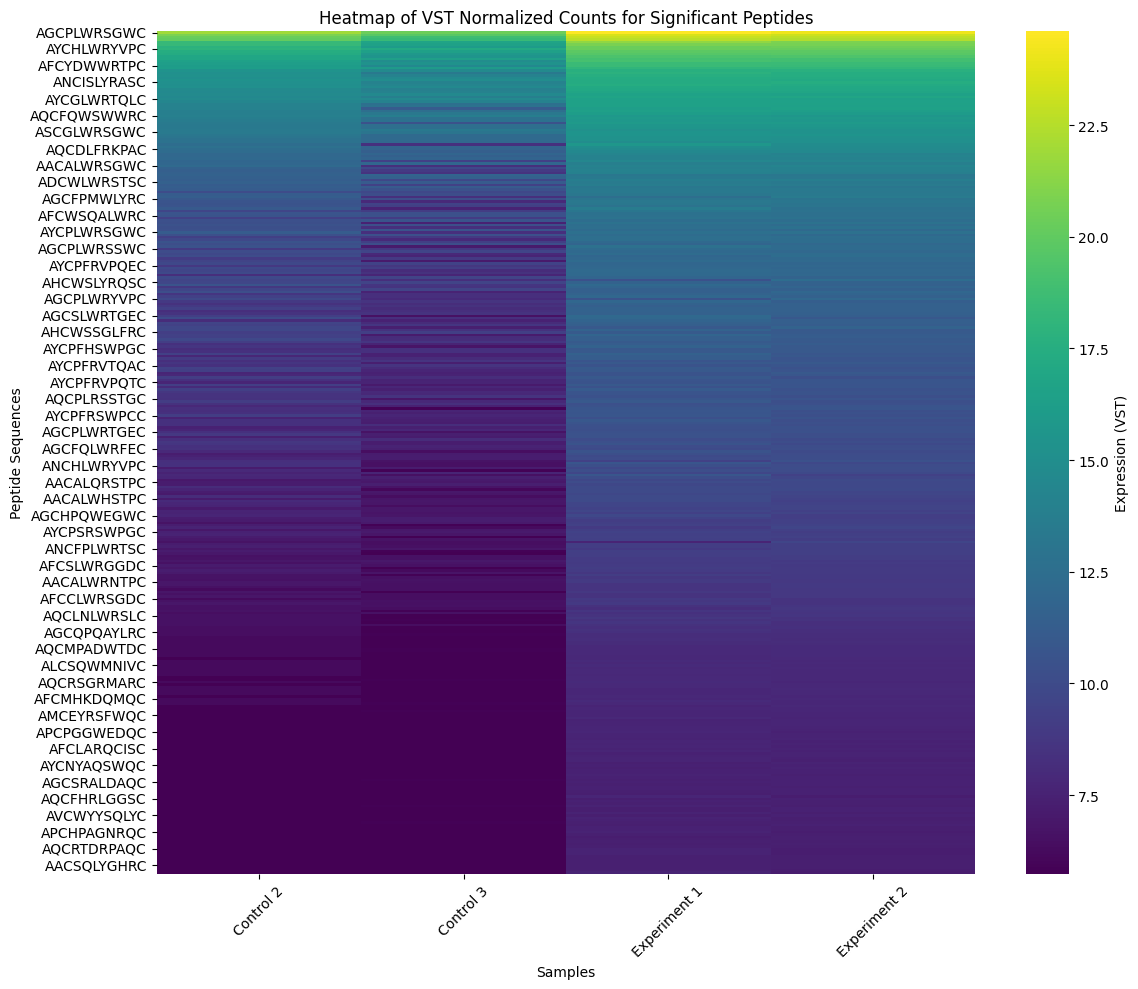

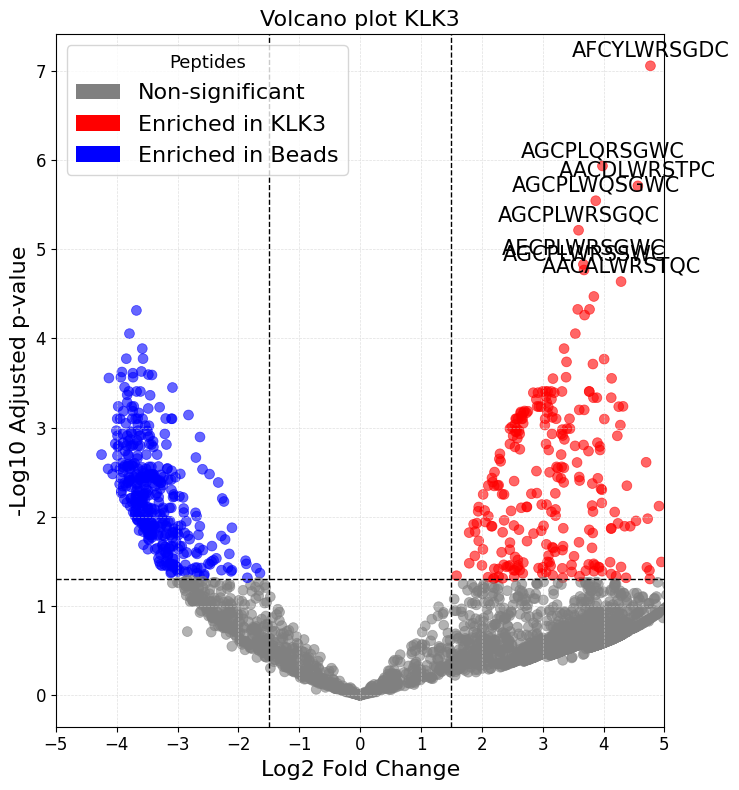

In [281]:
plot_heatmap(vst_up_peptides)
volcano_plot(res_df, "/Volumes/Elements/Data_PlasmaKallikrein/Results/Plots/VolcanoPlot.pdf")

In [ ]:
# # Define constant positions to remove
# constant_positions = (0, 2, 10)

# # Apply transformations
# res_df_1["variable_pep"] = res_df_1.index.map(lambda x: remove_constant(x, constant_positions))
# res_df_1["additional_cys"] = res_df_1["variable_pep"].apply(lambda peptide: "C" in peptide)
# res_df_1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10(padj),updown,variable_pep,additional_cys
Clean Peptide,,,,,,,,,,
AYCGYNLQAGC,3.256443e+07,-8.512656,0.071506,-119.047359,0.000000,0.000000,10.000000,down,YGYNLQAG,False
AFCHPQNEHSC,2.702363e+07,-8.157830,0.067454,-120.938881,0.000000,0.000000,10.000000,down,FHPQNEHS,False
ATCTTRHPQFC,2.029756e+07,-8.686679,0.076422,-113.667331,0.000000,0.000000,10.000000,down,TTTRHPQF,False
ASCVHPQFMAC,1.141103e+07,-8.660244,0.077203,-112.174924,0.000000,0.000000,10.000000,down,SVHPQFMA,False
AQCFFHPQFLC,8.420835e+06,-8.665069,0.086984,-99.616884,0.000000,0.000000,10.000000,down,QFFHPQFL,False
...,...,...,...,...,...,...,...,...,...,...
ASCANHQSRKC,8.200423e+00,3.156900,1.198719,2.633561,0.008449,0.030586,1.514473,up,SANHQSRK,False
ASCTFRPPFDC,1.314231e+01,0.261450,0.556925,0.469452,0.638747,0.797967,0.098015,not_significant,STFRPPFD,False
AGCRSHVYWQC,1.352719e+01,0.318917,0.562671,0.566790,0.570857,0.750453,0.124676,not_significant,GRSHVYWQ,False


In [35]:

# Filter out peptides with additional cysteine
adj_DE_filtered = res_df_1.loc[~res_df_1["additional_cys"]].drop(columns=["additional_cys"]).reset_index()

# Save upregulated peptides for clustering
adj_DE_filtered[adj_DE_filtered["updown"] == "up"][["variable_pep"]].to_csv(
    "Upregulated_peptides_Variable.pep", sep='\t', index=False, header=False
)
adj_DE_filtered[adj_DE_filtered["updown"] == "up"][["Clean Peptide"]].to_csv(
    "Upregulated_peptides.pep", sep='\t', index=False, header=False
)

adj_DE_filtered

,Clean Peptide,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10(padj),updown,variable_pep
0,AYCGYNLQAGC,3.256443e+07,-8.512656,0.071506,-119.047359,0.000000,0.000000,10.000000,down,YGYNLQAG
1,AFCHPQNEHSC,2.702363e+07,-8.157830,0.067454,-120.938881,0.000000,0.000000,10.000000,down,FHPQNEHS
2,ATCTTRHPQFC,2.029756e+07,-8.686679,0.076422,-113.667331,0.000000,0.000000,10.000000,down,TTTRHPQF
3,ASCVHPQFMAC,1.141103e+07,-8.660244,0.077203,-112.174924,0.000000,0.000000,10.000000,down,SVHPQFMA
4,AQCFFHPQFLC,8.420835e+06,-8.665069,0.086984,-99.616884,0.000000,0.000000,10.000000,down,QFFHPQFL
...,...,...,...,...,...,...,...,...,...,...
68505,AYCLQLQSYDC,1.314732e+01,0.204337,0.547381,0.373299,0.708926,0.843726,0.073798,not_significant,YLQLQSYD
68506,ASCANHQSRKC,8.200423e+00,3.156900,1.198719,2.633561,0.008449,0.030586,1.514473,up,SANHQSRK
68507,ASCTFRPPFDC,1.314231e+01,0.261450,0.556925,0.469452,0.638747,0.797967,0.098015,not_significant,STFRPPFD
68508,AGCRSHVYWQC,1.352719e+01,0.318917,0.562671,0.566790,0.570857,0.750453,0.124676,not_significant,GRSHVYWQ


In [32]:
# Save sequences for upregulated and downregulated peptides
for regulation, filename in [("up", "upregulated"), ("down", "downregulated")]:
    save_as_fasta(adj_DE_filtered[adj_DE_filtered["updown"] == regulation]["Clean Peptide"].tolist(), f"{filename}.fasta")
    save_as_fasta(adj_DE_filtered[adj_DE_filtered["updown"] == regulation]["variable_pep"].tolist(), f"{filename}_variable.fasta")

# Generate WebLogo plots
weblogo_params = [
    ("upregulated.fasta", "upregulated.pdf", "Enriched - Original"),
    ("upregulated_variable.fasta", "upregulated_variable.pdf", "Enriched - Trimmed"),
    ("downregulated.fasta", "downregulated.pdf", "Disenriched - Original"),
    ("downregulated_variable.fasta", "downregulated_variable.pdf", "Disenriched - Trimmed"),
]
for input_fasta, output_pdf, title in weblogo_params:
    generate_weblogo(input_fasta, output_pdf, title)

print("WebLogo plots generated and saved as PDFs!")


WebLogo plots generated and saved as PDFs!


In [36]:
# Perform clustering analysis
num_clusters = 4
clustering_dir = gibbs_cluster("Upregulated_peptides.pep", 11, 4, "/Volumes/Elements/Data_KLK3/Results/Clustering", "KLK3_clustering_results", logos=True)
clusters = parse_gibbscluster_output(f"{clustering_dir}/res/gibbs.{num_clusters}g.ds.out")
clusters.groupby(by="Gn").count()["Num"]

GibbsCluster run 'KLK3_clustering_results' completed successfully.
Find the results in :/Volumes/Elements/Data_KLK3/Results/Clustering/KLK3_clustering_results_6551
/Volumes/Elements/Data_KLK3/Results/Clustering/KLK3_clustering_results_6551/cores/gibbs.1of4.core
Generated WebLogo for Cluster 1: /Volumes/Elements/Data_KLK3/Results/Clustering/KLK3_clustering_results_6551/logos/cluster_1.pdf
/Volumes/Elements/Data_KLK3/Results/Clustering/KLK3_clustering_results_6551/cores/gibbs.2of4.core
Generated WebLogo for Cluster 2: /Volumes/Elements/Data_KLK3/Results/Clustering/KLK3_clustering_results_6551/logos/cluster_2.pdf
/Volumes/Elements/Data_KLK3/Results/Clustering/KLK3_clustering_results_6551/cores/gibbs.3of4.core
Generated WebLogo for Cluster 3: /Volumes/Elements/Data_KLK3/Results/Clustering/KLK3_clustering_results_6551/logos/cluster_3.pdf
/Volumes/Elements/Data_KLK3/Results/Clustering/KLK3_clustering_results_6551/cores/gibbs.4of4.core
Generated WebLogo for Cluster 4: /Volumes/Elements/Data_K

/var/folders/6c/n4y8nj3n08v_qs9c0hqbpnl40000gn/T/ipykernel_6292/1950626630.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, skiprows=1,


Gn
1    17
2    16
3    21
4    45
Name: Num, dtype: int64

/var/folders/6c/n4y8nj3n08v_qs9c0hqbpnl40000gn/T/ipykernel_6292/677062001.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_col, y=y_col, data=df, showfliers=False, palette="Set2",


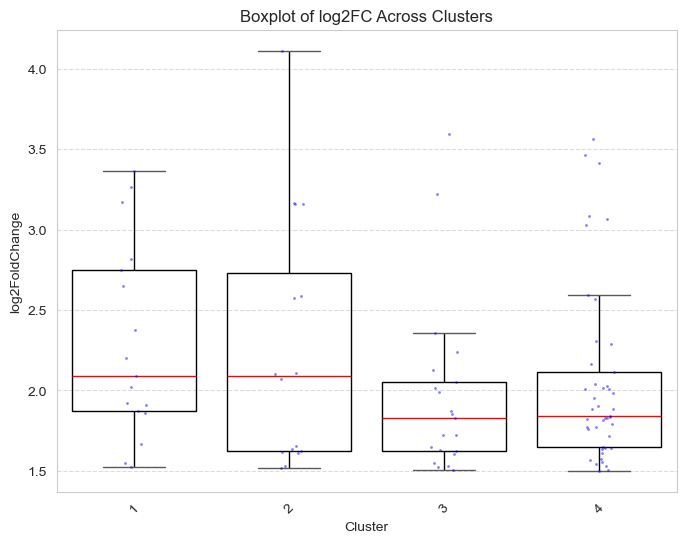

/var/folders/6c/n4y8nj3n08v_qs9c0hqbpnl40000gn/T/ipykernel_6292/677062001.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_col, y=y_col, data=df, showfliers=False, palette="Set2",


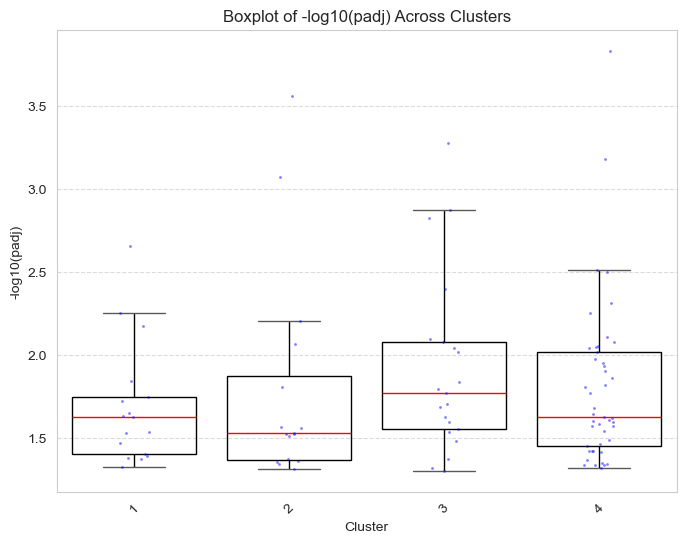

/var/folders/6c/n4y8nj3n08v_qs9c0hqbpnl40000gn/T/ipykernel_6292/677062001.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_col, y=y_col, data=df, showfliers=False, palette="Set2",


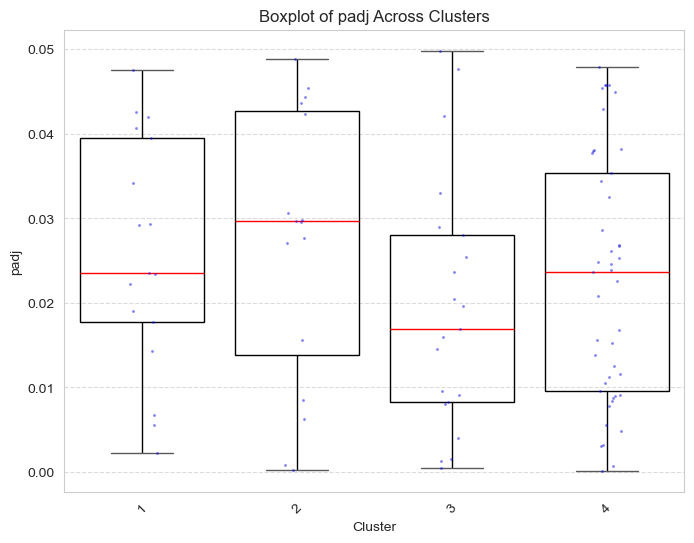

In [37]:

adj_DE_filtered.rename(columns={"Clean Peptide":"Sequence"}, inplace=True)

clusters = pd.merge(clusters,adj_DE_filtered[["Sequence","log2FoldChange","padj","-log10(padj)"]])
box_plot(clusters, "Gn", "log2FoldChange", "Boxplot of log2FC Across Clusters")
box_plot(clusters, "Gn", "-log10(padj)", "Boxplot of -log10(padj) Across Clusters")
box_plot(clusters, "Gn", "padj", "Boxplot of padj Across Clusters")

In [27]:

top_sequences = top_n_per_cluster(clusters,100)
for cluster_id, sequences in sorted(top_sequences.items()):
    print(f"Cluster {cluster_id}:")
    for seq in sequences:
        print(f"  {seq}")
    print("-" * 10)          


Cluster 1:
  ATCRQTMWGLC
  AVCQTPVSVLC
  AGCQTWRWPRC
  ASCWNSIALSC
  ATCTQSQRAVC
  AGCFRAPWTMC
  ANCKQSPTMLC
  ASCQMGIAWLC
  ASCREWPETPC
  ASCLQWQWWQC
  ARCWAEVMTQC
  ATCKSPPGGQC
  ASCLGTVMPQC
  AICRYGPASSC
  AVCKGSQVSKC
----------
Cluster 2:
  ARCTWPWWSQC
  ASCYWSWGSKC
  AMCRNLYWQDC
  AWCYVRAWESC
  AWCSYLYKPPC
  ARCPPDWRDLC
  AWCGVGRWGYC
  APCMLQFWGLC
  AWCSLGAWRAC
  ASCSWTKGQPC
  AGCGWPAWGVC
  AFCPGGWGSAC
  AWCTQGRAGWC
  ATCHLGRSAHC
  AWCAWEQARQC
  ASCPMARGYAC
  AICSWQFTNWC
  AMCPPQAVQHC
----------
Cluster 3:
  AKCEHEDGMRC
  AGCEEWNRGRC
  AGCEVVTETLC
  AGCETWQEEGC
  AWCIKWADIGC
  ANCLHYDDQYC
----------
Cluster 4:
  AHCKSMPSRNC
  AGCAARVPAGC
  AHCRAHYQVSC
  ASCMAARGWNC
  ADCMGQLQGPC
  AECAGRYPWRC
  AGCASSRVVPC
  AKCGKVPTRPC
----------
